## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from collections import Counter

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
lower_text = [e.lower() for e in text]
text = ''.join(lower_text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [6]:
# Join all the strings into one and lowercase it
# Put result into variable text.
lower_text = [e.lower() for e in text]
text = ''.join(lower_text)
Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
out = set()
for w in text:
    out.update(set(w))

tokens = sorted(set(out))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [6]:
batch_size = 256

def prepare_data(text, tokens, token_to_idx, idx_to_token, seq_len, step = 1):
    sentences, next_tokens = [], []
    for i in range(0, len(text) - seq_len, step):
        sentences.append(text[i : i + seq_len])
        next_tokens.append(text[i + seq_len])
    x = np.zeros((len(sentences), seq_len, len(tokens)))
    y = np.zeros((len(sentences), len(tokens)))
    for i, sentence in enumerate(sentences):
        for t, token in enumerate(sentence):
            x[i, t, token_to_idx[token]] = 1
        y[i, token_to_idx[next_tokens[i]]] = 1  
    return x, y

In [7]:
x, y = prepare_data(text, tokens, token_to_idx, idx_to_token, seq_len = 64, step = 1)

In [8]:
x.shape, y.shape

((100161, 64, 38), (100161, 38))

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
class VanillaRNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128,
                 n_layers = 1):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embedding = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        h_seq, h = self.rnn(x_emb, h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_rnn = VanillaRNN()
model_rnn.to(device)

opt = torch.optim.Adam(model_rnn.parameters())
model_rnn.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 20
history = []
_ = model_rnn.train()

for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_rnn.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        opt.zero_grad()
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)


        seq, hidden_state = model_rnn(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
        hidden_state = hidden_state.detach()

    history.append(np.mean(ep_history))
    print(f'Loss after the epoch {epoch + 1} is {history[-1]}')

Loss after the epoch 1 is 2.250314276236707
Loss after the epoch 2 is 1.9842031736812933
Loss after the epoch 3 is 1.9100817179740848
Loss after the epoch 4 is 1.8677554798248175
Loss after the epoch 5 is 1.8372664811361172
Loss after the epoch 6 is 1.8138892595725291
Loss after the epoch 7 is 1.7967583773386142
Loss after the epoch 8 is 1.78134466071263
Loss after the epoch 9 is 1.772265812929939
Loss after the epoch 10 is 1.7569767358662831
Loss after the epoch 11 is 1.751299542234377
Loss after the epoch 12 is 1.7405535757084332
Loss after the epoch 13 is 1.735293446294487
Loss after the epoch 14 is 1.7274066907975374
Loss after the epoch 15 is 1.7207894386232967
Loss after the epoch 16 is 1.7130636958514942
Loss after the epoch 17 is 1.7086279084310507
Loss after the epoch 18 is 1.7036241960647467
Loss after the epoch 19 is 1.701109147132815
Loss after the epoch 20 is 1.6937498793272716


Plot the loss function (axis X: number of epochs, axis Y: loss function).

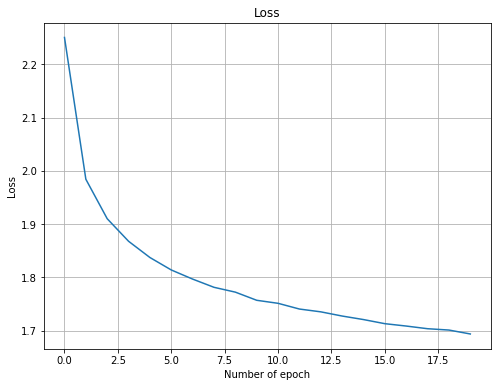

In [15]:
# Your plot code here

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history)
plt.title('Loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [33]:
def generate_sample(char_rnn, tokens = tokens, seed_phrase = ' Thee eye ', 
                    max_length = 100, temperature = 1., flag = False):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
  
    def sample(preds, tokens, temperature = 1.):
        preds =  F.softmax(preds / temperature, dim = -1).cpu().data.numpy().squeeze()
        # print(preds.shape)
        next_ix = np.random.choice(len(tokens), p = preds)
        return torch.LongTensor([[next_ix]])

    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, i].long()]), hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        next_ix = sample(out, tokens, temperature)
        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)
    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [39]:
print(generate_sample(model_rnn, tokens = tokens, seed_phrase = ' Thee eye ', 
                      max_length = 500, temperature = 0.3, flag = False))

 thee eye for thy seen to the with the heart that it my doth thou my can thou deton when as thee, me and to the strengel in my fate is those chast thou doth this so the then my hate thee, then thy that thou have thee,
  the true it the are thee that thy sound should the me the self thy pore thou beto grove that i stot is fact to my all me to my dear that thou art thy prease i be the with thy wate's from the repont thou when it thou then thee thee thy the bellest thee my doth then the say that wh


In [40]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [41]:
class LSTM_net (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1):
        super(LSTM_net, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

model_lstm = LSTM_net()
opt = torch.optim.Adam(model_lstm.parameters())
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()

n_epochs = 20
history = []
_ = model_lstm.train()
for epoch in range(n_epochs):
    ep_history = []
    hidden_state = model_lstm.initial_state(batch_size)
    for batch_ind in range(batch_size, x.shape[0], batch_size):
        
        x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
        y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

        hidden_state = tuple([each.data for each in hidden_state])

        opt.zero_grad()
    
        seq, hidden_state = model_lstm(x_batch, hidden_state)
        loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
        loss.backward()
        opt.step()  
        ep_history.append(loss.item())
    history.append(np.mean(ep_history))
    print(f'Loss after the epoch {epoch + 1} is {history[-1]}')

Loss after the epoch 1 is 2.078810658906122
Loss after the epoch 2 is 1.699354009860007
Loss after the epoch 3 is 1.5697484391424663
Loss after the epoch 4 is 1.492843456280506
Loss after the epoch 5 is 1.4369866180297968
Loss after the epoch 6 is 1.3891923653195277
Loss after the epoch 7 is 1.3489409532693342
Loss after the epoch 8 is 1.3137710841415484
Loss after the epoch 9 is 1.2817745480086187
Loss after the epoch 10 is 1.246560661993978
Loss after the epoch 11 is 1.2153220923660357
Loss after the epoch 12 is 1.1853757191192158
Loss after the epoch 13 is 1.15412896795346
Loss after the epoch 14 is 1.122852953041301
Loss after the epoch 15 is 1.090381140751607
Loss after the epoch 16 is 1.0589159167636082
Loss after the epoch 17 is 1.0291123408490739
Loss after the epoch 18 is 1.0018332129549188
Loss after the epoch 19 is 0.9754986313297925
Loss after the epoch 20 is 0.9509448631645163


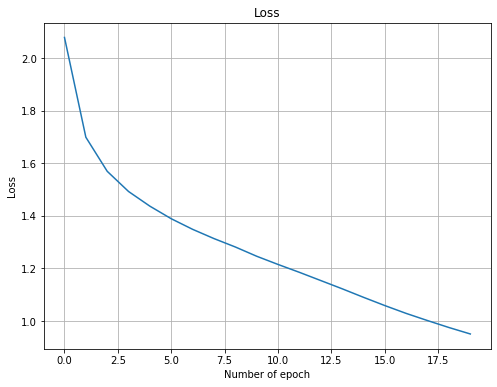

In [42]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history)
plt.title('Loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [45]:
# Text generation with different temperature values here
temperature_collection = [0.1, 0.2, 0.5, 1.0, 2.0]
for temp in temperature_collection:
    print(f'Temperature is {temp}')
    print(generate_sample(model_lstm, tokens = tokens, seed_phrase = ' Thee eye ', 
                          max_length = 500, temperature = temp, flag = False))
    print('----------------')

Temperature is 0.1
 thee eye is me,
    and then the truth that i have see the worst,
  when i am thy self thou art thou art the worst,
  when thou thy self thy sweet self desire
  the worst thou thy self thy sweet self doth lie,
  do i not love is as the state of thy side,
  but i do i not so do not so deep,
    and then the truth that i do conceit on me,
    and then the truth that i do conceit on thee,
  that i do conceit of thy beauty's love to sing
  that i do constant on thy sweet self desire?
  o! no! not i
----------------
Temperature is 0.2
 thee eye asur'd,
    and then the truth that i do conceit on thee,
  that i do constant and thee i so despair,
    and then the truth that i have seen to my heart,
  the confess'd i thy beauty's love is best,
  whilst i that thou then my friend and i may,
  deserv'd then my love that thou art the worst,
  when thou art thou though i my thought thee how mad desert,
  and i no more that thou art thou art the worst,
  when thou thy self thy s

Temperature is a hyperparameter that controls the randomness of predictions by scaling the logits before applying softmax. It can be noticed that generated texts with higher temperature have more mistakes since higher temperature increases the sensitivity to low probability candidates. On the other hand with low temperature obtained texts have less diversity and more repeats. To me for this task the text with temperature = 0.5 seems the best.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [50]:
# Saving and loading code here
torch.save(model_lstm.state_dict(), 'fitted_LSTM.net')

model = LSTM_net(n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1)
model.load_state_dict(torch.load('fitted_LSTM.net'))
model.eval()

LSTM_net(
  (embed): Embedding(38, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [52]:
print(generate_sample(model, tokens = tokens, seed_phrase = ' Greetings ', 
                      max_length = 500, temperature = 0.4, flag = False))

 greetings to be,
    and thence thou mayst thou art thou art the vill,
  and i do i not from the fairest in my sin,
    lest thy self thou lov'st thou thy self dross,
  or what then my that i have still love that then in thy heart,
    and then thou lov'st the worst thou in love,
  and thou thou lov'st to my best express'd
  for i have seen the paint of thy beauty's live?
    but in the world i love that thou less my name,
  creating thy sweet from my soul doth lies do not to my mind,
    and y


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)